In [1]:
import radarsimpy
radarsimpy.__version__


'11.1.0'

# Micro-Doppler

<a href="https://radarsimx.github.io/radarsimpy/" target="_blank" rel="nofollow"><img src="https://img.shields.io/badge/Documentation-latest-brightgree?style=flat&logo=read-the-docs" height="20"></a>
<a href="https://radarsimx.com/product/radarsimpy/" target="_blank"><img src="https://img.shields.io/badge/Download-latest-brightgree?style=flat&logo=python" height="20"></a>

This is an example of using [`RadarSimPy`](https://radarsimx.com/radarsimx/radarsimpy/) to simulate micro-Doppler effect.

---

## Setup FMCW radar

### Transmitter

Setup the basic transmitter parameters through `Transmitter` module.

The following table lists the parameters in this example.

 | Parameter                       | Variable in `Transmitter` | Value                          |
 | ------------------------------- | ------------------------- | ------------------------------ |
 | Frequency ($f$)                 | `f`                       | [24e9-4000e6, 24e9+4000e6] GHz |
 | Time ($T$)                      | `t`                       | 300e-6 s                       |
 | Transmitted power ($P_t$)       | `tx_power`                | 15 dBm                         |
 | Pulse repetition period ($PRP$) | `prp`                     | 0.0025 s                       |
 | Number of pulses                | `pulses`                  | 1280                           |
 
### Receiver

Setup the receiver parameters through `Receiver` module.

The parameters of the receiver are listed in the table below.

 | Parameter                        | Variable in `Receiver` | Value        |
 | -------------------------------- | ---------------------- | ------------ |
 | Sampling rate ($f_s$)            | `fs`                   | 2 Msps       |
 | Noise figure ($NF$)              | `noise_figure`         | 8 dB         |
 | RF gain/loss ($G_{rf}$)          | `rf_gain`              | 20 dB        |
 | Load resistor ($R_L$)            | `load_resistor`        | 500 $\Omega$ |
 | Baseband voltage gain ($G_{BB}$) | `baseband_gain`        | 30 dB        |


In [2]:
import numpy as np
from radarsimpy import Radar, Transmitter, Receiver

tx_channel = dict(
    location=(0, 0, 0),
)

tx = Transmitter(f=[24e9-4000e6, 24e9+4000e6],
                 t=300e-6,
                 tx_power=25,
                 prp=0.0025,
                 pulses=1280,
                 channels=[tx_channel])

rx_channel = dict(
    location=(0, 0, 0),
)

rx = Receiver(fs=2e6,
              noise_figure=6,
              rf_gain=20,
              load_resistor=500,
              baseband_gain=30,
              channels=[rx_channel])

radar = Radar(transmitter=tx, receiver=rx)


In [3]:
target_1 = {
    'model': '../models/turbine.stl',
    'location': (5, 0, 0),
    'rotation': (0, 0, 0),
    'rotation_rate': (0, 30, 0),
    'speed': (0, 0, 0)
}

targets = [target_1]


In [4]:
from radarsimpy.rt import scene
import time

tic = time.time()
data = scene(radar, targets, density=1, level='pulse')
baseband = data['baseband']
toc = time.time()

print('Exec time:', toc-tic, 's')


Exec time: 373.2414870262146 s


## Range-Doppler processing

In [5]:
from scipy import signal
import radarsimpy.processing as proc

range_window = signal.chebwin(radar.samples_per_pulse, at=60)
doppler_window = signal.chebwin(radar.transmitter.pulses, at=60)
range_doppler = np.fft.fftshift(proc.range_doppler_fft(baseband, rwin=range_window, dwin=doppler_window), axes=1)


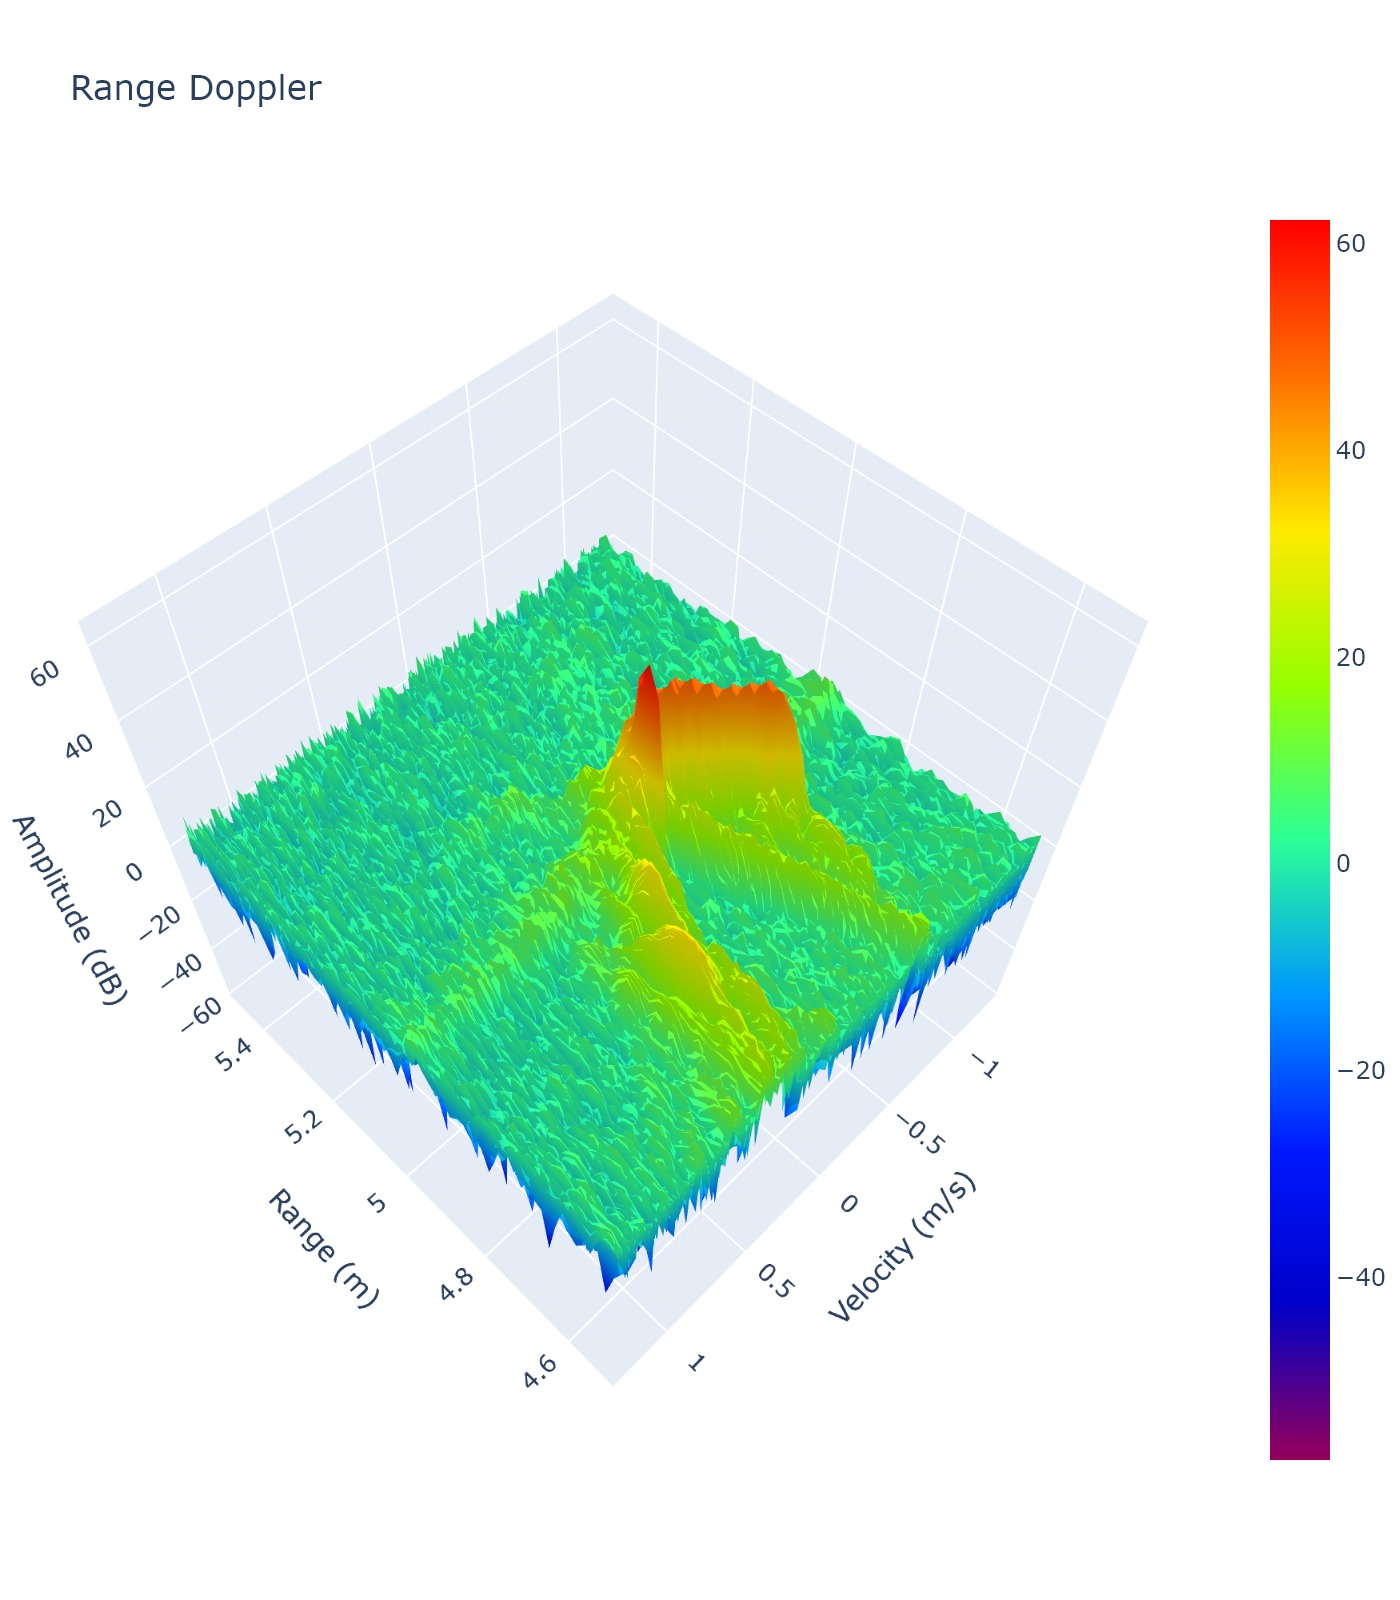

In [6]:
import plotly.graph_objs as go
from IPython.display import Image

temp = np.abs(range_doppler[0, :, :])
temp = 20 * np.log10(temp)

max_range = (3e8 * radar.receiver.fs *
             radar.transmitter.pulse_length /
             radar.transmitter.bandwidth / 2)
unambiguous_speed = 3e8 / radar.transmitter.prp[0] / \
    radar.transmitter.fc_vect[0] / 2

range_axis = np.linspace(
    0, max_range, radar.samples_per_pulse, endpoint=False)

rng_idx = np.where(np.logical_and(range_axis > 4.5, range_axis < 5.5))

doppler_axis = np.linspace(
    -unambiguous_speed/2, unambiguous_speed/2, radar.transmitter.pulses, endpoint=False)

fig = go.Figure()

fig.add_trace(go.Surface(x=range_axis[rng_idx[0]], y=doppler_axis,
                         z=temp[:, rng_idx[0]], colorscale='Rainbow'))

camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=-1, y=1, z=2)
)

fig.update_layout(
    title='Range Doppler',
    height=800,
    scene=dict(
        xaxis=dict(title='Range (m)', range=[4.5, 5.5]),
        yaxis=dict(title='Velocity (m/s)'),
        zaxis=dict(title='Amplitude (dB)'),
        aspectmode='cube',
        camera=camera,
    ),
    margin=dict(l=0, r=0, b=60, t=100),
    legend=dict(orientation='h'),
)

# fig.show()
Image(fig.to_image(format="jpg", scale=2))
